In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from tqdm import tqdm

from utils.config import Config
from models.base import ImageCaptioningModel
from models.attention_model import ImageCaptioningWithAttention
from data.data_set import DataSet
from text.tokenizer import Tokenizer
from pathlib import Path


In [61]:
RUN_ID = 14

In [62]:
# laod the prediction results
path_run = f"../models/checkpoints/run_{RUN_ID}"
predictions = pd.read_csv(f"{path_run}/results.csv")
predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)

# select best prediction for each image
best_predictions = predictions.loc[predictions.groupby('Image Name')['BLEU Score'].idxmax()]
best_predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)


MODEL_PATH = Path(f"../models/checkpoints/run_{RUN_ID}")

config = Config(experiment_id=RUN_ID)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = ImageCaptioningWithAttention(config.embed_size, config.attention_dim, config.decoder_dim, config.vocab_size, config.encoder_dim).to(device)
model.load_state_dict(torch.load(f"{MODEL_PATH}/best_model.pth", map_location=device, weights_only=True))


<All keys matched successfully>

In [71]:
# show image with true caption and predicted caption 
def show_image(image_name):
    path = "../data/raw/images/"
    true_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'True Caption'].values[0]
    predicted_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'Predicted Caption'].values[0]
    bleu_score = best_predictions.loc[best_predictions['Image Name'] == image_name, 'BLEU Score'].values[0]
    plt.figure(figsize=(10, 8))
    plt.imshow(Image.open(f"{path}/{image_name}"))
    plt.title(f"True Caption: {true_caption.replace('  ', '')}\nPredicted Caption: {predicted_caption.strip()}\nBLEU Score: {bleu_score}",fontsize=12, pad=10, wrap=True)
    plt.axis('off')
    plt.show()
    
def visualize_features_overlay(image_name, model, alpha=0.4):
    """
    Visualize mean feature activation overlaid on the original image
    """
    path = "../data/raw/images/"
    image = Image.open(f"{path}/{image_name}").convert("RGB")
    with torch.no_grad():
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
        ])
        image = transform(image)
        features = model.encoder(image.unsqueeze(0).to(device))

        mean_features = features.mean(dim=1).squeeze().cpu()
        mean_features = (mean_features - mean_features.min()) / (mean_features.max() - mean_features.min())

        plt.figure(figsize=(10, 8))

        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]
        plt.imshow(img_np)
        
        mean_features_resized = F.interpolate(
            mean_features.unsqueeze(0).unsqueeze(0), 
            size=img_np.shape[:2], 
            mode='bilinear', 
            align_corners=False
        ).squeeze().numpy()
        
        plt.imshow(mean_features_resized, cmap='hot', alpha=alpha)
        plt.axis('off')
        plt.show()
            

In [72]:
best_predictions.head()

,True Caption,Predicted Caption,Image Name,BLEU Score
4049,a brown dog swims in the murky water ...,a brown dog jumping in the water .,443430496_3fea95a07d.jpg,0.772185
4048,three dogs are playing in the grass ...,two dogs playing standing in the grass .,1926129518_4350f4f552.jpg,0.750000
4046,four dogs playing in the snow ...,two dogs playing on the snow .,2333584535_1eaf9baf3e.jpg,0.714286
4047,two dogs fighting in the snow ...,one dogs are in the snow .,3122497129_d08f5729b8.jpg,0.714286
4043,a small white dog in the snow ...,a brown dog is running in the snow .,2295894587_2fd8faf550.jpg,0.666667


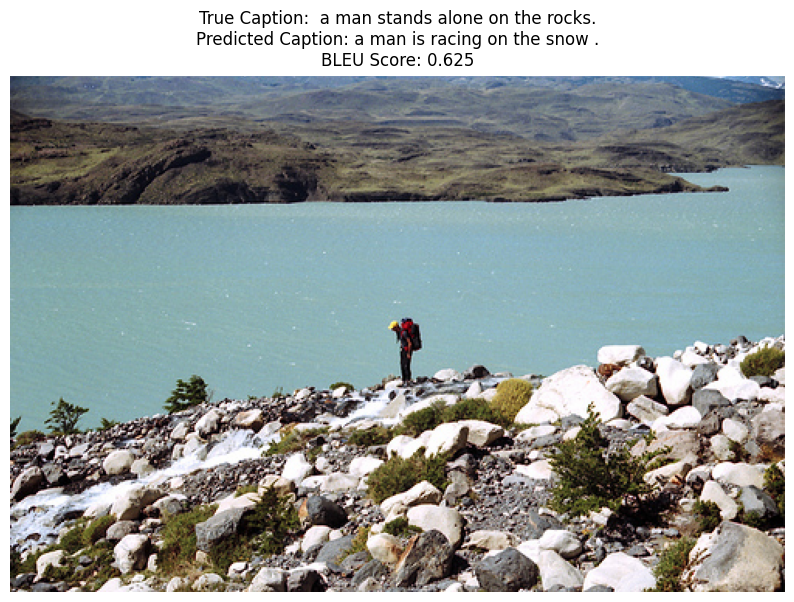

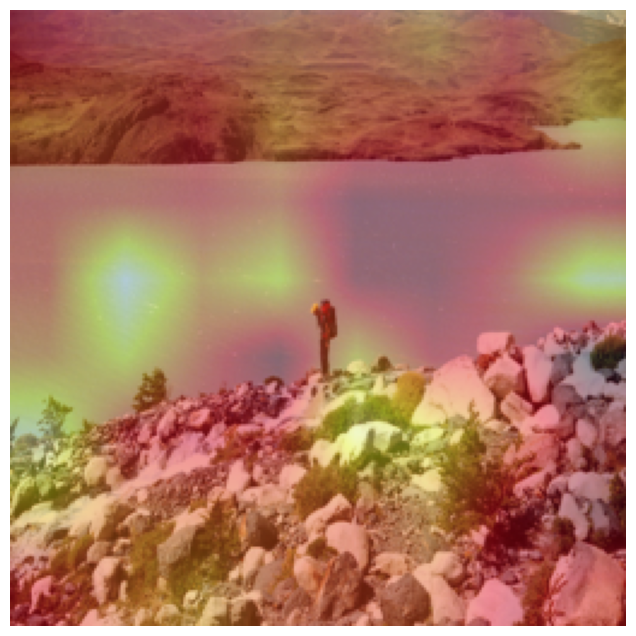

In [73]:
index = 10
image_name = best_predictions['Image Name'].iloc[index]
show_image(image_name)
visualize_features_overlay(image_name, model)


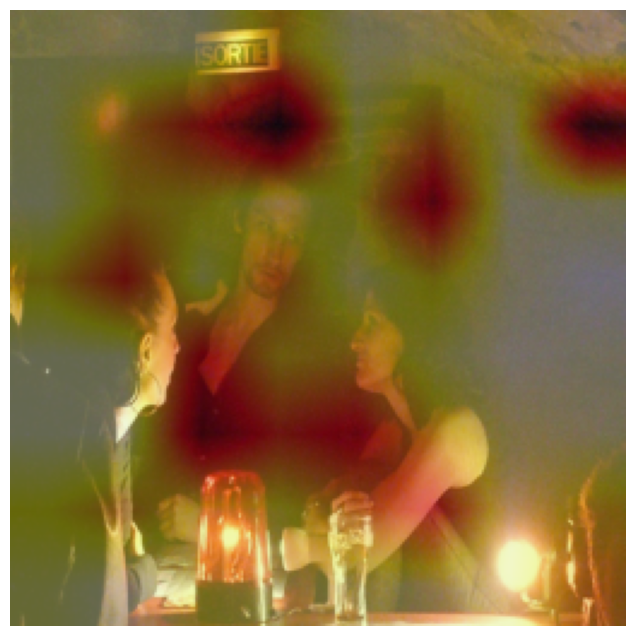

In [39]:


path = "../data/raw/images/"
image_name = best_predictions['Image Name'].iloc[10]
image = Image.open(f"{path}/{image_name}").convert("RGB")

visualize_features_overlay(image, model)

